<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4 : Job Market Analysis

### Notebook 03: Predictive Model Building

---

## Contents
- [1.0 Introduction](#Intro)
- [2.0 Factors Impacting Salary](#salary)
    - [2.1 Methodology](#sal_methodology)
    - [2.2 Data preprocessing](#sal_preprocess)
    - [2.3 Fitting regression models](#reg_models)
    - [2.4 Top salary predictors](#sal_top)
- [3.0 Trending Buzzwords for Job Category](#factor_jobcat)
    - [3.1 Methodology](#cat_methodology)
    - [3.2 Data preprocessing](#cat_preprocess)
    - [3.3 Fitting classification models](#cl_models)
    - [3.4 Top buzzwords for each category](#keywords)
    - [3.5 Job category word clouds](#cloud)
- [4.0 Conclusion & Future Considerations](#conclusion)


## 1.0 Introduction <a name="Intro"></a>
The goal of this project is to answer the following questions:
1. Which factors in the job market have the most affect on salary?
2. Is it possible to identify the key skills and buzzwords across job category / title?

In order to answer the above questions, I will gather data from the job search site [SEEK Limited AU](https://www.seek.com.au/). For this project I will limit the study to available jobs in data related fields (e.g. data science, data analyst etc) in the Sydney and Melbourne areas.

I will be splitting this project in 3 notebooks as follows:
- Notebook 01: Data Gathering (Web Scrape)
- Notebook 02: Data Cleaning and Exporatory Analysis
- **Notebook 03: Predictive Model Building**

In [62]:
# General Libraries
import pandas as pd
import numpy as np
from itertools import product
import warnings
from tqdm import tqdm

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing, modelling & evaluation
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score,  accuracy_score, precision_recall_fscore_support
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Language Processing
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

I will pick up from where I left in Notebook 02. This notebook will focus on identifing key factors impacting salaries and job categories. Let us start by reading in the dataset we saved after completing our EDA in Notebook 02:

In [63]:
seek = pd.read_csv('./datasets/final_data.csv')
seek.columns = ['searched', 'city', 'original_job_title', 'advertiser',
       'advertiser_rating', 'date_posted', 'original_salary', 'work_type', 'original_industry',
       'category', 'job_description', 'url', 'job_title',
       'industry', 'exp_level', 'salary', 'salary_type']
seek.head(2)

,searched,city,original_job_title,advertiser,advertiser_rating,date_posted,original_salary,work_type,original_industry,category,job_description,url,job_title,industry,exp_level,salary,salary_type
0,data-analyst,All-Sydney-NSW,Data Analyst (Digital),Seventh Street Ventures,NaN,23-Apr-19,"$60,000 - $70,000 plus Super",Contract/Temp,Information & Communication Technology,Business/Systems Analysts,About Us Seventh Street Ventures is an entrepr...,https://www.seek.com.au/job/38866940?type=prom...,data analyst,information_technology,2 Mid-Level,70000.0,year
1,data-analyst,All-Sydney-NSW,Data Quality Analyst - Oracle Enterprise Data ...,Capgemini,2.7,2-May-19,na,Full Time,Information & Communication Technology,Engineering - Software,About the Team\nOur Insights and Data team hel...,https://www.seek.com.au/job/38929211?type=stan...,data analyst,information_technology,2 Mid-Level,200000.0,year


## 2.0 Factors Impacting Salary <a name="salary"></a>
### 2.1 Methodology <a name="sal_methodology"></a>
To identify the key factors contributing to salary, I will be building a predictive model and look at the weightage the model provides to my features. I will be using a Regressor for this activity.

In [64]:
# Checking the baseline
print('Baseline for Model Performance: {:,.2f}'.format(seek['salary'].mean()))

Baseline for Model Performance: 143,353.15


I will loop through all model algorithms using (mostly) the default values, to see what is the performance of each model. Assuming that the models are better than the baseline, I will see for the top performing models which features they are giving the most importance.

However before moving to the building the model, the features need to be extracted, pruned and preprocessed.

### 2.2 Data preprocessing <a name="sal_preprocess"></a>
Getting the data ready for modelling involves the following steps:
1. Getting rid of all unnecessary features
2. Dummifying the categorical columns

In [65]:
feature_subset = seek[['city', 'work_type', 'job_title', 'exp_level', 'salary_type', 'industry']].copy()
feature_subset.head(3)

,city,work_type,job_title,exp_level,salary_type,industry
0,All-Sydney-NSW,Contract/Temp,data analyst,2 Mid-Level,year,information_technology
1,All-Sydney-NSW,Full Time,data analyst,2 Mid-Level,year,information_technology
2,All-Sydney-NSW,Contract/Temp,data analyst,2 Mid-Level,year,information_technology


In [66]:
feature_subset['salary_type'].value_counts()

year    2530
day      227
hour      48
week      16
Name: salary_type, dtype: int64

In [67]:
# Converting city
feature_subset['city'] = feature_subset['city'].map(lambda x: 1 if 'Sydney' in x else 0)

# Converting work_type
dummies_wt = pd.get_dummies(feature_subset['work_type']).drop(['Casual/Vacation','Part Time'], axis=1)
feature_subset = pd.concat([feature_subset, dummies_wt], axis=1).drop('work_type', axis=1)

# Converting job_title
dummies_jt = pd.get_dummies(feature_subset['job_title']).drop(['data engineer'], axis=1)
feature_subset = pd.concat([feature_subset, dummies_jt], axis=1).drop('job_title', axis=1)

# Converting exp_level
feature_subset['exp_level'] = feature_subset['exp_level'].map(lambda x: 1 if 'Junior' in x else 2 if 'Mid' in x else 3)

# Converting salary_type
sal_dict = {'hour': 0, 'day': 1, 'week': 2, 'year': 3}
feature_subset['salary_type'] = feature_subset['salary_type'].map(lambda x: sal_dict[x])

# Convert industry
dummies_ind = pd.get_dummies(feature_subset['industry']).drop(['gov_health','other'], axis=1)
feature_subset = pd.concat([feature_subset, dummies_ind], axis=1).drop('industry', axis=1)

feature_subset.head(3)

,city,exp_level,salary_type,Contract/Temp,Full Time,business analyst,data analyst,data scientist,financial_services,information_technology,sales_marketing,science_technology
0,1,2,3,1,0,0,1,0,0,1,0,0
1,1,2,3,0,1,0,1,0,0,1,0,0
2,1,2,3,1,0,0,1,0,0,1,0,0


In [68]:
X_train, X_test, y_train, y_test = train_test_split(feature_subset, np.log(seek['salary']), 
                                                    test_size=0.25, shuffle=True, random_state=25)

ss = StandardScaler().fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2115, 12), (706, 12), (2115,), (706,))

Our features are ready for the model. Let's proceed with testing the linear regression.

### 2.3 Fitting regression models <a name="reg_models"></a>
In the next step I am going to define a loop which will iteratively run each model using the default settings, and save the performance results in a dictionary. I will then use the model results to identify top performing models, which I will fine-tune and use for top feature identification.

In [69]:
lr = LinearRegression(n_jobs=-1)
svr = SVR()
rfr = ExtraTreesRegressor(random_state=3, n_jobs=-1)
knn = KNeighborsRegressor(n_jobs=-1)

lr_params = {'fit_intercept': [True]}
svr_params = {'kernel': ['poly', 'rbf']}
rfr_params = {'n_estimators': [500, 750, 1000]}
knn_params = {'n_neighbors': [9, 10, 11],'p': [1, 2]}

models = [lr, svr, rfr, knn]
model_params = [lr_params, svr_params, rfr_params, knn_params]
train_r2 = []
train_r2_cv = []
test_r2 = []
trained_models = []
best_estimators = []

In [70]:
for i, model in enumerate(models):
    print('Training and testing for {}...'.format(str(model).split('(')[0]))
    est = GridSearchCV(model, model_params[i], n_jobs=-1, cv=5).fit(X_train, y_train)
    train_r2_cv.append(est.best_score_)
    train_r2.append(r2_score(y_train, est.predict(X_train)))
    test_r2.append(r2_score(y_test, est.predict(X_test)))
    best_estimators.append(est.best_estimator_)
    trained_models.append(est)
    print('Best estimator:')
    print(est.best_estimator_)
    print('='*50)

Training and testing for LinearRegression...
Best estimator:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
Training and testing for SVR...
Best estimator:
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)
Training and testing for ExtraTreesRegressor...
Best estimator:
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
          oob_score=False, random_state=3, verbose=0, warm_start=False)
Training and testing for KNeighborsRegressor...
Best estimator:
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=10, p=1,
          weight

In [71]:
model_scores = pd.DataFrame({'train_r2': train_r2, 'train_r2_cv': train_r2_cv, 'test_r2': test_r2},\
                            index=['LinearRegression', 'SVR', 'ExtraTreeRegressor', 'KNN']).T
model_scores

,LinearRegression,SVR,ExtraTreeRegressor,KNN
train_r2,0.463591,0.582350,0.657131,0.567635
train_r2_cv,0.461815,0.523809,0.537100,0.516634
test_r2,0.427010,0.488199,0.529028,0.521390


The best performance is given by the ExtraTreeRegressor, followed by K-Neighbors Regressor. Unfortunately, the K-Nearest Neighbor does not provide feedback on feature importance so it cannot be used as a feature value identification tool. 

### 2.4 Top salary predictors <a name="sal_top"></a>
Below I will check feature rankings for Extra Tree and Linear Regression models. I will also check the feature importance using some feature selection methods.

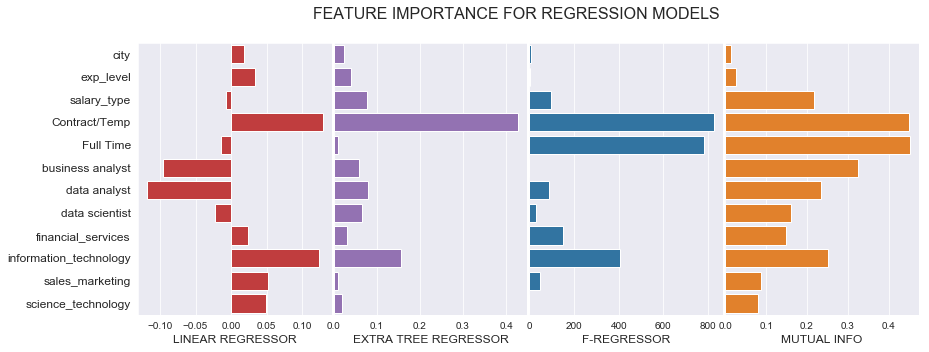

In [72]:
# Identify Coefficients of Linear Regression
lr_coefs = pd.DataFrame(index=feature_subset.columns, data={'reg_coef':best_estimators[0].coef_})

# Get Feature Importance of ExtraTreeRegressor
et_ranking = pd.DataFrame(index=feature_subset.columns, data={'tree_imp':best_estimators[2].feature_importances_})

# Get Feature Rank Using SelectKBest
k_best = SelectKBest(mutual_info_regression).fit(X_train, y_train)
feat_rank = pd.DataFrame(index=feature_subset.columns, data={'select_k':k_best.scores_})

fig, ax = plt.subplots(1,4, figsize=(14,5), sharey=True)

# Plot Regression Coefficients
sns.barplot(y=lr_coefs.index, x=lr_coefs['reg_coef'], ax=ax[0], color='C3')

# Plot ExtraTree Ranks
sns.barplot(y=et_ranking.index, x=et_ranking['tree_imp'], ax=ax[1], color='C4')

# Plot Select Best using different formulas
colors = ['C0', 'C1']
for i, formula in enumerate([f_regression, mutual_info_regression]):
    k_best = SelectKBest(formula).fit(X_train, y_train)
    feat_rank = pd.DataFrame(index=feature_subset.columns, data={'select_k':k_best.scores_})
    sns.barplot(y=feat_rank.index, x=feat_rank['select_k'], ax=ax[i+2], color=colors[i])

plt.subplots_adjust(wspace=0.01)
ax[0].set_yticklabels(lr_coefs.index, fontsize=12)
ax[0].set_xlabel('LINEAR REGRESSOR', fontsize=12)
ax[1].set_xlabel('EXTRA TREE REGRESSOR', fontsize=12)
ax[2].set_xlabel('F-REGRESSOR', fontsize=12)
ax[3].set_xlabel('MUTUAL INFO', fontsize=12)
plt.suptitle('FEATURE IMPORTANCE FOR REGRESSION MODELS', fontsize=16)
plt.show()

Let us assess the above charts to see if we can identify the top contributors to salary:
- **city** shows negligible contribution to the salary (this was already identified during EDA).
- **exp_level** has some impact on salary, but it is marginally low.
- Type of contract plays an important role in defining salary (although 'Full Time' has a lower coefficient, added variance is high in salary prediction).
- Job title has a moderate impact. However, it is important to note here that many job titles have overlapping job responsibilities. We may see a much picture if we also use the professional skills as a feature in our model (we will look at this later in the notebook).
- Pay type (daily, weekly etc) seems to have moderate impact on salary.
- Industry has a moderate to high impact on salary (especially Information Technology, as we have already seen during the EDA stage).

Based on the above assessment, I can list the top impacters of salary in order as follows:
1. Contract Type (e.g. Permanent, Contract Employment)
2. Industry (e.g. Financial Services, Sales & Marketing)
3. Job Title (e.g. Data Analyst, Business Analyst)
4. Pay Type (e.g. annual, per day etc)

## 3.0 Trending Buzzwords for Job Category <a name="factor_jobcat"></a>
### 3.1 Methodology <a name="cat_methodology"></a>
The next step is to identify what are the top sought after skills for each job category. In order to do that, I will use the job description provided in the job advertisements, using natural language processing techniques. I will then build a classification model and check the importance of top keywords appearing for each job category.

To reduce dimensionality while keeping feature variation, I will be using the Lemmatizer in the NLTK library. This will change variations in different words and convert all such instances back to the root word, thus avoiding unnecessary repetitions. Before building the model, I will use the Tf-Idf Vectorizer to transform my documents to vectors, and then run some models on it.

### 3.2 Data preprocessing <a name="cat_preprocess"></a>
The below code defines a lemmatizing function, and using the same on the job descriptions. I am then using a random train-test split on the data.

In [73]:
#Define lemmatizing function
def lemm_it(doc):
    lemmed = ' '.join([WordNetLemmatizer().lemmatize(w, pos='v') for w in word_tokenize(doc)])
    lemmed2 = ' '.join([WordNetLemmatizer().lemmatize(w, pos='n') for w in word_tokenize(lemmed)])
    return lemmed2

# Lemmatize job descriptions, and split the data
X = seek['job_description'].map(lemm_it)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, seek['job_title'], shuffle=True, random_state=74, test_size=0.25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2115,), (706,), (2115,), (706,))

I am expecting that there will be many unnecessary words which are being assessed for importance, and I would like to remove those from the calculation. I will append all such words to a custom stop-word list, prepared by appending the original stop-word list available in scikit-learn.

Following that, I will simply use the Tf-idf vectorizer and transform my train and test data to make ready for modelling.

**Note**: I populated the stop-word list using trial and error methods using multiple runs of this program.

In [75]:
# Defining custom stop words
custom_stop_words = ['analytics', 'requirements', 'ability', 'services', 'solutions', 'opportunity', 'new', 'key',
                     'client', 'ba', 'requirement', 'understand', 'scientist', 'engineer', 'science', 'use', 'tool',
                     'expertise', 'business', 'role', 'data', 'work', 'project', 'therapy', 'forever', 'energyaustralia',
                     'capgemini', 'problem', 'physical', 'perfect', 'ensure', 'people', 'interdependency', 'effectiveness'
                     'analyst', 'trade', 'basket', 'flybuys', 'autism', 'eligibility']
custom_stop_words = list(ENGLISH_STOP_WORDS) + custom_stop_words

In [76]:
# Transform Job Descriptions to vectors
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, sublinear_tf=True, max_df=0.5, ngram_range=(1,1))
vectorizer.fit(X_train, y_train)
X_train_vec = pd.DataFrame(vectorizer.transform(X_train).todense(), columns=vectorizer.get_feature_names())
X_test_vec = pd.DataFrame(vectorizer.transform(X_test).todense(), columns=vectorizer.get_feature_names())
X_train_vec.shape, X_test_vec.shape, y_train.shape, y_test.shape

((2115, 17462), (706, 17462), (2115,), (706,))

### 3.3 Fitting classification models <a name="cl_models"></a>
Below I am defining a function which will take in a estimator class, and provide me the output of that model while also printing out the performance metrics. Using this function I will try out a Logistic Regression with different hyper-parameter settings to find the optimum model.

In [77]:
def test_model(model, params, model_name='not_provided'):
    # Run grid search
    estimator = GridSearchCV(model, param_grid = params, n_jobs=-1, cv=5).fit(X_train_vec, y_train)
    
    # Print best estimator
    best_estimator = estimator.best_estimator_
    print('Best model:', best_estimator)
    
    # Print scores for best estimator
    train_pred = best_estimator.predict(X_train_vec)
    test_pred = best_estimator.predict(X_test_vec)
    train_precision, train_recall, _, _ = precision_recall_fscore_support(y_train, train_pred)
    test_precision, test_recall, _, _ = precision_recall_fscore_support(y_test, test_pred)
    print('Training Data:')
    print(' Business Analyst <==> Precision: {:.3f}, Recall: {:.3f}'.format(train_precision[0], train_recall[0]))
    print(' Data Analyst     <==> Precision: {:.3f}, Recall: {:.3f}'.format(train_precision[1], train_recall[1]))
    print(' Data Engineer    <==> Precision: {:.3f}, Recall: {:.3f}'.format(train_precision[2], train_recall[2]))
    print(' Data Scientist   <==> Precision: {:.3f}, Recall: {:.3f}'.format(train_precision[3], train_recall[3]))
    print('Testing Data:')
    print(' Business Analyst <==> Precision: {:.3f}, Recall: {:.3f}'.format(test_precision[0], test_recall[0]))
    print(' Data Analyst     <==> Precision: {:.3f}, Recall: {:.3f}'.format(test_precision[1], test_recall[1]))
    print(' Data Engineer    <==> Precision: {:.3f}, Recall: {:.3f}'.format(test_precision[2], test_recall[2]))
    print(' Data Scientist   <==> Precision: {:.3f}, Recall: {:.3f}'.format(test_precision[3], test_recall[3]))
    print('')
    baseline = seek['job_title'].value_counts(normalize=True).iloc[0]*100
    train_accuracy = accuracy_score(y_train, best_estimator.predict(X_train_vec)) 
    test_accuracy = accuracy_score(y_test, best_estimator.predict(X_test_vec))
    print('Baseline Score: {:.3f}%'.format(baseline))
    print('Overall Training Accuracy: {:.3f}%'.format(train_accuracy * 100))
    print('Overall Testing Accuracy: {:.3f}%'.format(test_accuracy * 100))
    
    return best_estimator

The best Logistic Regression is using L1 penalty and inverse regularization strength of 1.2.

In [78]:
lr = LogisticRegression(random_state=7)
params = {'penalty': ['l1'], 'C': [1.2]}

lrc_model = test_model(lr, params)

Best model: LogisticRegression(C=1.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=7, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Training Data:
 Business Analyst <==> Precision: 0.788, Recall: 0.969
 Data Analyst     <==> Precision: 0.725, Recall: 0.389
 Data Engineer    <==> Precision: 0.781, Recall: 0.362
 Data Scientist   <==> Precision: 0.757, Recall: 0.651
Testing Data:
 Business Analyst <==> Precision: 0.766, Recall: 0.940
 Data Analyst     <==> Precision: 0.590, Recall: 0.302
 Data Engineer    <==> Precision: 0.583, Recall: 0.389
 Data Scientist   <==> Precision: 0.818, Recall: 0.643

Baseline Score: 63.098%
Overall Training Accuracy: 77.825%
Overall Testing Accuracy: 74.221%


In [55]:
# Plot ROC curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
%precision 3

y_train_new = label_binarize(y_train, classes=['business analyst', 'data analyst', 'data engineer', 'data scientist'])
y_test_new = label_binarize(y_test, classes=['business analyst', 'data analyst', 'data engineer', 'data scientist'])

In [79]:
y_train_new.shape

(2115, 4)

In [56]:
classifier = OneVsRestClassifier(lrc_model, n_jobs=-1)
y_score = classifier.fit(X_train_vec, y_train_new).decision_function(X_test_vec)

In [81]:
y_score.shape

(706, 4)

In [60]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_train_new.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_new[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_new.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# Aggregate all false positives
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_train_new.shape[1])]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(y_train_new.shape[1]):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= y_train_new.shape[1]

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

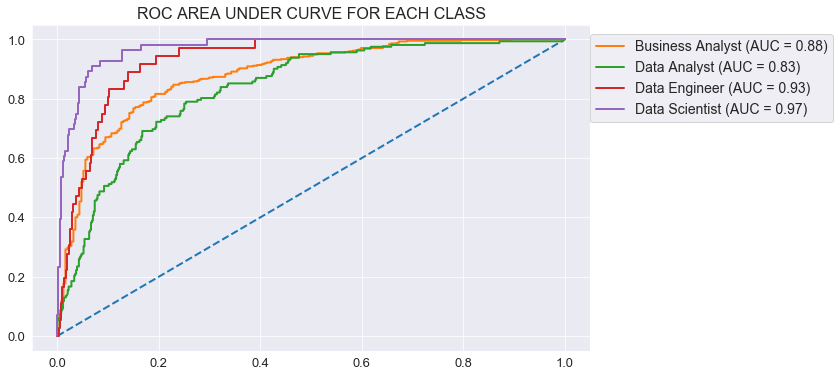

In [61]:
fig = plt.figure(figsize = (10, 6))
plt.plot([0,1], [0,1], linestyle='--', linewidth=2)
plt.plot(fpr[0], tpr[0], label='Business Analyst (AUC = %0.2f)'%roc_auc[0], linewidth=2)
plt.plot(fpr[1], tpr[1], label='Data Analyst (AUC = %0.2f)'%roc_auc[1], linewidth=2)
plt.plot(fpr[2], tpr[2], label='Data Engineer (AUC = %0.2f)'%roc_auc[2], linewidth=2)
plt.plot(fpr[3], tpr[3], label='Data Scientist (AUC = %0.2f)'%roc_auc[3], linewidth=2)
# plt.plot(fpr['micro'], tpr['micro'], label='Micro Average (AUC = %0.2f)'%roc_auc['micro'], ls=':', linewidth=3)
# plt.plot(fpr['macro'], tpr['macro'], label='Macro Average (AUC = %0.2f)'%roc_auc['macro'], ls='-.', linewidth=3)
plt.legend(loc=(1, 0.7), fontsize=14)
plt.title('ROC AREA UNDER CURVE FOR EACH CLASS', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

The AUC for ROC look good for the model. Let's consider this to be a good model for this exercise and find our inferences.

### 3.4 Top buzzwords for each category <a name="keywords"></a>
Now that I have my model ready, It's time to check which keywords have the highest weightage for each job category. Logistic Regression makes it quite easy, as it gives me the coefficient for each label class directly. Let's extract the top features for each class and plot them to see if it matches our expectations.

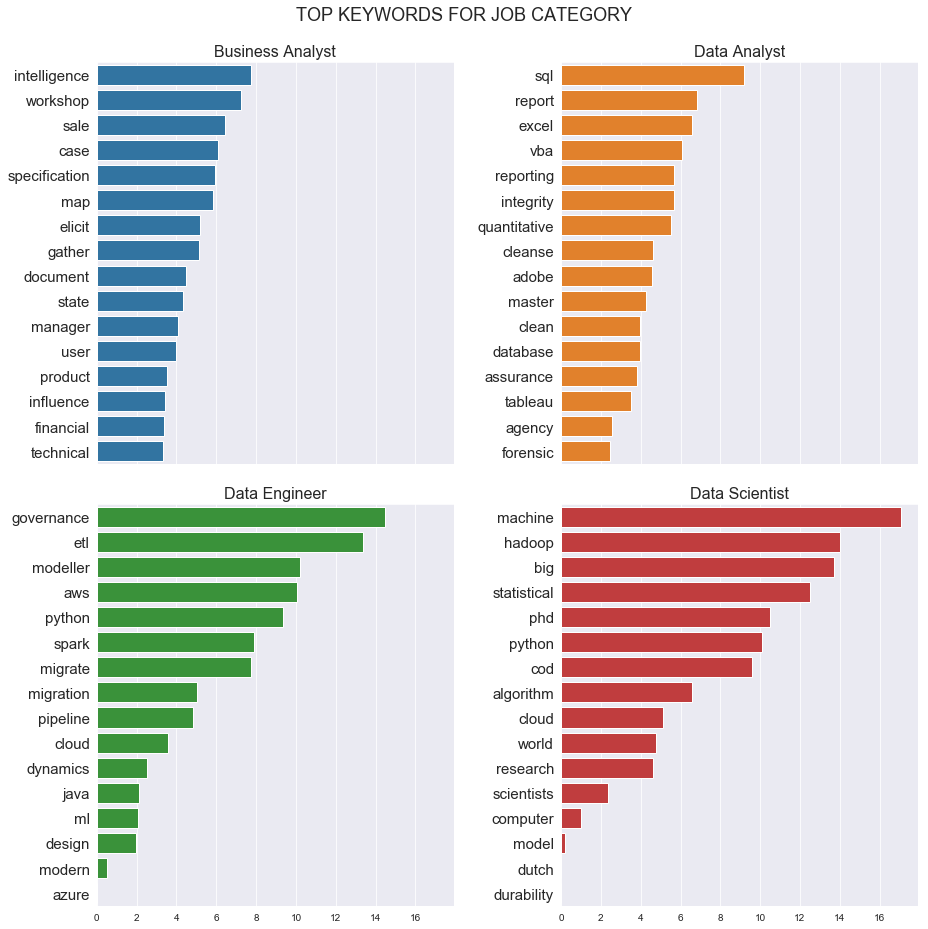

In [20]:
# Create dataframe for coefficients
lrc_counts = pd.DataFrame(lrc_model.coef_, columns=X_train_vec.columns, index=['BA', 'DA', 'DE', 'DS']).T

# Plot top keywords for each category
fig, ax = plt.subplots(2,2, figsize=(13,13), sharex=True)
c = ['C0', 'C1', 'C2', 'C3']
titles = ['Business Analyst', 'Data Analyst', 'Data Engineer', 'Data Scientist']
for i, ax in enumerate(ax.flat):
    plt.sca(ax)
    col = lrc_counts.columns[i]
    y = lrc_counts[col].sort_values(ascending=False).head(16).index
    x = lrc_counts[col].sort_values(ascending=False).head(16)
    sns.barplot(x=x, y=y, ax=ax, color=c[i])
    ax.set_yticklabels(y, fontsize=15)
    plt.title(titles[i], fontsize=16)
    plt.xlabel('')
    
plt.suptitle('TOP KEYWORDS FOR JOB CATEGORY', fontsize=18, va='center')
fig.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.1, top=0.93)
plt.show()

The top words differentiating most across job categories is pretty much as expected, I am getting the required skills that I would expect to find for that job. Some key finds for each job category as as below:
1. A Business Analyst would not be expected to have a big technical role, so most the skills we see in the chart are managerial in nature. We have keywords like 'manager', 'customer', 'influence', 'facilitate' and some tangentially technical words such as 'SAS' and 'workshop'.
2. The Data Analyst shows 'excel', 'vba', 'tableau', 'sql', and 'adobe' in the top 20 technical skills. This makes perfect sense as these are all well-known tools used by Data Analysts.
3. The Data Engineer depicts more of a cloud / database approach, having words like 'aws', 'etl', 'relational database', 'cloud formation', 'big query', 'pipeline' and 'spark'.
4. Keywords for Data Scientists do not exhibit as clear a pattern due to lesser obervations as well as vagueness in the job descriptions; however we can still see some key relevant words such as 'machine', 'python', 'hadoop' and 'algorithm'. A very important thing to observe here is that 'PhD' is picked up as a imporant keyword. This shows that Data Scientists in Australia are expected to have, or atleast are preferred if they have a higher education.

### 3.5 Job category word clouds <a name="cloud"></a>
I have already identified words which are high separators of job categories. Let us look at the job categories from a different perspective; I will create word-clouds (because no NLP project is complete without one) of each job category to see if there are any words which are highly repeated by job advertisers.

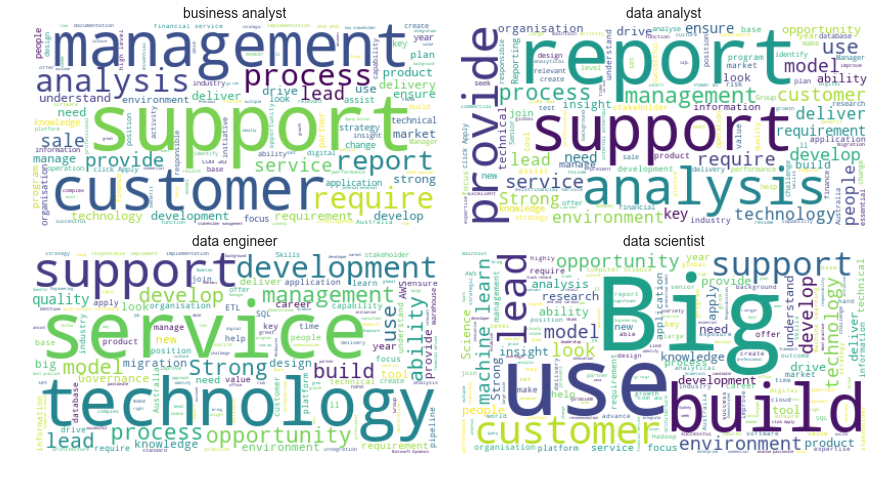

In [21]:
from wordcloud import WordCloud, ImageColorGenerator

cloud_stopwords = list(ENGLISH_STOP_WORDS) + ['data','analyst','analytics','scientist','business', 'experience', 'team',
                                              'solution', 'project', 'role', 'work', 'working', 'client', 'engineer',
                                              'skill', 'include', 'company']

fig, ax = plt.subplots(2,2, figsize=(15, 8))
for i, title in enumerate(['business analyst', 'data analyst', 'data engineer', 'data scientist']):
    plt.sca(ax.flat[i])
    text = ' '.join(desc for desc in seek[seek['job_title']==title]['job_description'].map(lambda x: lemm_it(x)))
    cloud = WordCloud(stopwords=cloud_stopwords, background_color='white').generate(text)
    plt.sca(ax.flat[i])
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.show()

Some interesting insights here:
1. 'Support' and 'Customer' are predominantly used by job advertisers for Business Analyst positions. This shows that the major role of a Business Analyst is customer support and management, and less to do with using technical tools.
2. Advertisers rely on 'Support', 'Analysis' and 'Reporting' heavily for Data Analysts, which makes sense from our own knowledge of a Data Analysts' common job responsibilities. It is interesting that no common tool for data analysis is widely advertised.
3. Most used words on Data Engineers job advertisement are 'development' and 'technology'. This may be because currently many companies are focused on going digital, and either creating or expanding their data storages onto cloud computing.
4. The biggest word is 'Big', which we can assume comes from Big Data, however no other term related to Data Science is frequently used. I can assume from this that advertisers do not have as clear an idea of the job requirements of a Data Scientist as they do of the other categories. Data Science in Australia is still an emerging profession, and will take a few more years untill a more concrete responsibility matrix or toolset is defined.

## 4.0 Conclusion & Future Considerations <a name="conclusion"></a>
In a series of 3 notebooks, I covered a detailed analysis of the job market in Sydney and Melbourne for jobs related to data (data analysts, scientists and engineers). I went over some interesting insights during the EDA, and also identified the key factors which affect salaries and top buzzwords for different job categories using basic Natural Language Processing and machine learning techniques.

It is however important to note that the data I had to work with was limited in quantity, while also having a significant imbalance across job categories and industries which was to be expected. Uexpectedly however, around 70% of the advertisers had not posted salaries. I have used statitical imputation to fill in the missing salaries using my domain knowledge; and judging from the machine learning results I was able to segregate the job categories quite well.

Some future improvements in this project can be made as below:
1. Using a larger dataset, to have a better learnt model. 
2. Using data provided by a recruitment firm instead of scraping from the web. This will give us some better insights on salaries and variations across industries.
3. We can answer some more questions, such as:
 - Are there any skills or requirements which differntiate across different industries?
 - Do job descriptions differ significantly across experience requirement, and if yes, how?
 
Unfortunately with the data at hand it is not possible to do a meaningful analysis to answer the above two questions. I may take up this project again if I have some better data available, and carry out a more thorough analysis of the Australian data job market.

_____________________________________________________________________________
**-- NOTEBOOK 03 END --**